**Machine Learning - Transaction Data**

**Ali Fatta Maulana - 1103223228**

In [ ]:
!pip install -q gdown

# kalian download semua file dari gdrive dibawah lalu buat folder (ex. midterm_folder)
!gdown --folder 1JvI5xhPfN3VmjpWYZk9fCHG41xG697um -O midterm_folder

Retrieving folder contents
Processing file 1ALveidCmKzk4p_liQ7b663BXL0PcTaFN test_transaction.csv
Processing file 1Ujh37a1kTarNf3dSOSrj-hKDswULebYA train_transaction.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1ALveidCmKzk4p_liQ7b663BXL0PcTaFN
From (redirected): https://drive.google.com/uc?id=1ALveidCmKzk4p_liQ7b663BXL0PcTaFN&confirm=t&uuid=889ae46d-eae9-4d49-9d10-85f261baf3c5
To: /content/midterm_folder/test_transaction.csv
100% 613M/613M [00:04<00:00, 138MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Ujh37a1kTarNf3dSOSrj-hKDswULebYA
From (redirected): https://drive.google.com/uc?id=1Ujh37a1kTarNf3dSOSrj-hKDswULebYA&confirm=t&uuid=dfeb8b20-a8ef-43e4-b8b3-b523fe265f52
To: /content/midterm_folder/train_transaction.csv
100% 683M/683M [00:08<00:00, 82.2MB/s]
Download completed


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc  # Garbage Collector (Pembersih Memori)
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ==========================================
# KONFIGURASI PATH & RAM
# ==========================================
BASE_PATH = "midterm_folder"  # [FIXED] Folder tempat file csv berada

# PENTING:
# Gunakan 100000 dulu untuk memastikan kode jalan lancar tanpa crash.
# Jika RAM Colab masih kuat, baru ubah jadi None (load semua).
#N_ROWS = 100000
N_ROWS = None

# Fungsi Penghemat Memori (Wajib untuk Colab Free)
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)
    print(f'   RAM dihemat: {start_mem:.2f} MB -> {df.memory_usage().sum() / 1024**2:.2f} MB')
    return df


[TAHAP 1] MEMULAI EDA...
   Loading sampel data dari midterm_folder/train_transaction.csv...


/tmp/ipython-input-2787179827.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='isFraud', data=df_eda, palette='pastel')


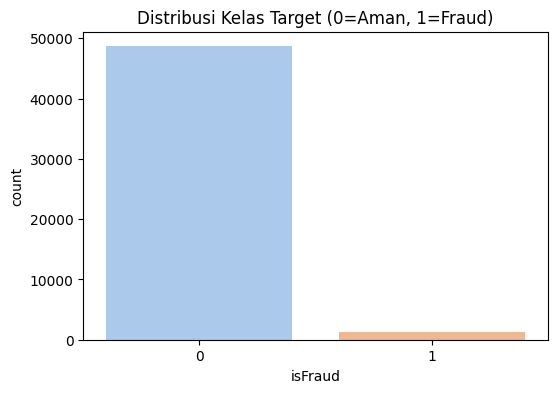

   Insight: Ditemukan 1357 transaksi fraud dari sampel.


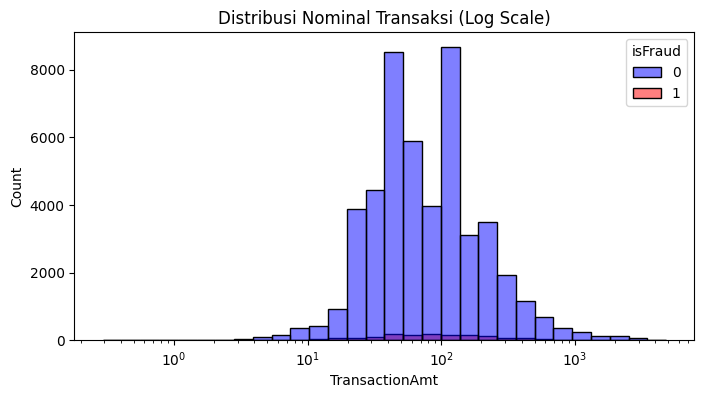

   Selesai EDA. Menghapus data EDA dari RAM...


In [ ]:
# ==================================================================================
# TAHAP 1: EXPLORATORY DATA ANALYSIS (EDA)
# ==================================================================================
print("\n[TAHAP 1] MEMULAI EDA...")

try:
    # [FIXED] Baca dari midterm_folder dan hanya 50rb baris
    print(f"   Loading sampel data dari {BASE_PATH}/train_transaction.csv...")
    df_eda = pd.read_csv(f'{BASE_PATH}/train_transaction.csv', nrows=50000)

    # 1. Visualisasi Class Imbalance
    plt.figure(figsize=(6, 4))
    sns.countplot(x='isFraud', data=df_eda, palette='pastel')
    plt.title('Distribusi Kelas Target (0=Aman, 1=Fraud)')
    plt.show()

    fraud_count = len(df_eda[df_eda['isFraud']==1])
    print(f"   Insight: Ditemukan {fraud_count} transaksi fraud dari sampel.")

    # 2. Visualisasi Transaksi Amount
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_eda, x='TransactionAmt', hue='isFraud', bins=30, log_scale=True, palette={0:'blue', 1:'red'})
    plt.title('Distribusi Nominal Transaksi (Log Scale)')
    plt.show()

    print("   Selesai EDA. Menghapus data EDA dari RAM...")
    del df_eda
    gc.collect()

except FileNotFoundError:
    print(f"ERROR FATAL: File tidak ditemukan di {BASE_PATH}. Pastikan step download sudah dijalankan!")
    raise # Hentikan program jika file tidak ada

In [ ]:
# ==================================================================================
# TAHAP 2: PREPROCESSING & DATA SPLIT
# ==================================================================================
print("\n[TAHAP 2] LOADING & PREPROCESSING DATA LATIH...")

# Load Data Train
print(f"   Loading Data Train (Maks Baris: {N_ROWS if N_ROWS else 'ALL'})...")
train = pd.read_csv(f'{BASE_PATH}/train_transaction.csv', nrows=N_ROWS)
train = reduce_mem_usage(train) # [FIXED] Langsung kecilkan ukuran memori

# Pisahkan Target & Fitur
y = train['isFraud']
X = train.drop(['isFraud', 'TransactionID'], axis=1)

# Hapus variabel 'train' mentah segera untuk hemat RAM
del train
gc.collect()

# Encoding & Handling Missing Values
print("   Melakukan Label Encoding & Handling NaN...")
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str).fillna('unknown'))
    else:
        X[col] = X[col].fillna(-999)

# Split Data (80% Train, 20% Validasi)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Hapus X dan y awal
del X, y
gc.collect()

# Buat Dataset khusus LightGBM (Lebih efisien memori daripada Pandas DF biasa)
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)


[TAHAP 2] LOADING & PREPROCESSING DATA LATIH...
   Loading Data Train (Maks Baris: ALL)...


/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning:

   RAM dihemat: 1775.15 MB -> 542.35 MB
   Melakukan Label Encoding & Handling NaN...


In [ ]:
# ==================================================================================
# TAHAP 3: HYPERPARAMETER TUNING (BASIC) - FIXED VERSION
# ==================================================================================
print("\n[TAHAP 3] HYPERPARAMETER TUNING...")
print("   Membandingkan Model A (Standard) vs Model B (Agresif)...")

# Kita gunakan CPU saja agar stabil dan tidak error CUDA
# LightGBM di CPU sudah sangat cepat untuk ukuran data ini.

# Kandidat 1: Model Konservatif
params_1 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'scale_pos_weight': ratio,
    'verbose': -1,
    'n_jobs': -1,
    'device': 'cpu'  # [FIXED] Ubah ke CPU
}

# Kandidat 2: Model Agresif
params_2 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'scale_pos_weight': ratio,
    'verbose': -1,
    'n_jobs': -1,
    'device': 'cpu'  # [FIXED] Ubah ke CPU
}

# Training Model A
print("   -> Training Model A...")
model_a = lgb.train(
    params_1,
    dtrain,
    num_boost_round=500,
    valid_sets=[dval], # Hanya ada 1 validasi, jadi namanya 'valid_0'
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(0) # 0 berarti tidak mencetak log per iterasi (biar rapi)
    ]
)
# [FIXED] Ganti 'valid_1' menjadi 'valid_0'
score_a = model_a.best_score['valid_0']['auc']

# Training Model B
print("   -> Training Model B...")
model_b = lgb.train(
    params_2,
    dtrain,
    num_boost_round=500,
    valid_sets=[dval],
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(0)
    ]
)
# [FIXED] Ganti 'valid_1' menjadi 'valid_0'
score_b = model_b.best_score['valid_0']['auc']

print(f"\n   HASIL: AUC Model A={score_a:.4f} | AUC Model B={score_b:.4f}")

if score_a > score_b:
    print("   KESIMPULAN: Memilih Model A.")
    final_model = model_a
else:
    print("   KESIMPULAN: Memilih Model B.")
    final_model = model_b


[TAHAP 3] HYPERPARAMETER TUNING...
   Membandingkan Model A (Standard) vs Model B (Agresif)...
   -> Training Model A...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.947824
   -> Training Model B...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.965146

   HASIL: AUC Model A=0.9478 | AUC Model B=0.9651
   KESIMPULAN: Memilih Model B.



[TAHAP 4] EVALUASI MODEL...
   Final ROC-AUC Score: 0.9651

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    113975
           1       0.44      0.83      0.58      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.90      0.78    118108
weighted avg       0.97      0.96      0.96    118108



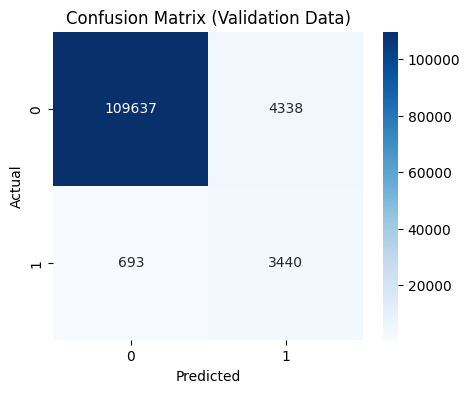

4296

In [ ]:
# ==================================================================================
# TAHAP 4: EVALUASI MODEL
# ==================================================================================
print("\n[TAHAP 4] EVALUASI MODEL...")

y_pred_prob = final_model.predict(X_val)
auc_score = roc_auc_score(y_val, y_pred_prob)
print(f"   Final ROC-AUC Score: {auc_score:.4f}")

# Threshold 0.5
y_pred_bin = [1 if x >= 0.5 else 0 for x in y_pred_prob]

print("\nClassification Report:")
print(classification_report(y_val, y_pred_bin))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_bin), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Data)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# [FIXED] Bersihkan RAM besar-besaran sebelum load Data Test
del X_train, X_val, y_train, y_val, dtrain, dval, model_a, model_b
gc.collect()

In [ ]:
# ==================================================================================
# TAHAP 5: PREDIKSI & SUBMISSION
# ==================================================================================
print("\n[TAHAP 5] MEMBUAT FILE SUBMISSION...")

# Load Data Test (Hanya load saat dibutuhkan)
print(f"   Loading Data Test dari {BASE_PATH}/test_transaction.csv...")
test = pd.read_csv(f'{BASE_PATH}/test_transaction.csv', nrows=N_ROWS)
test = reduce_mem_usage(test) # Optimasi Memory

submission_ids = test['TransactionID']
X_test = test.drop(['TransactionID'], axis=1)

del test
gc.collect()

# Preprocessing Data Test (Sama seperti Train)
print("   Preprocessing Data Test...")
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        le = LabelEncoder()
        X_test[col] = le.fit_transform(X_test[col].astype(str).fillna('unknown'))
    else:
        X_test[col] = X_test[col].fillna(-999)

# Prediksi
print("   Melakukan Prediksi...")
test_pred = final_model.predict(X_test)

# Simpan
submission = pd.DataFrame({
    'TransactionID': submission_ids,
    'isFraud': test_pred
})
submission.to_csv('submission_final.csv', index=False)
print("SELESAI! File 'submission_final.csv' telah berhasil dibuat.")


[TAHAP 5] MEMBUAT FILE SUBMISSION...
   Loading Data Test dari midterm_folder/test_transaction.csv...


/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-3789392981.py:39: RuntimeWarning:

   RAM dihemat: 1519.24 MB -> 472.59 MB
   Preprocessing Data Test...
   Melakukan Prediksi...
SELESAI! File 'submission_final.csv' telah berhasil dibuat.


Memuat file 'submission_final.csv'...
File berhasil dimuat. Total data: 506691 baris.


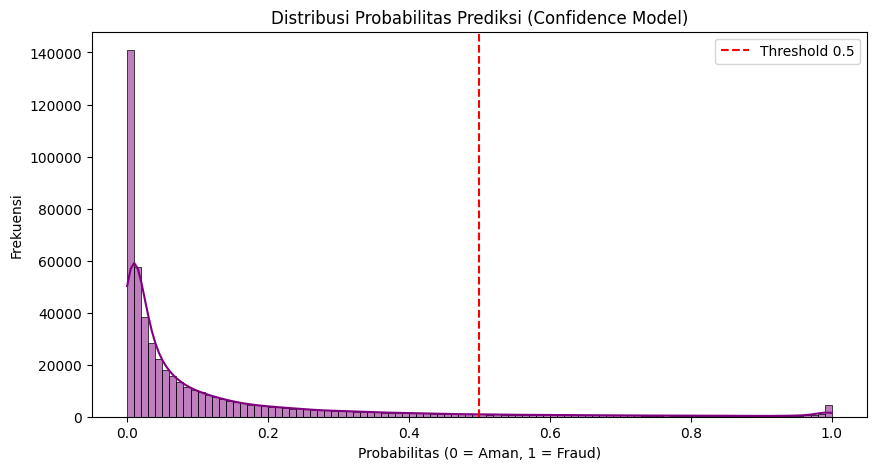

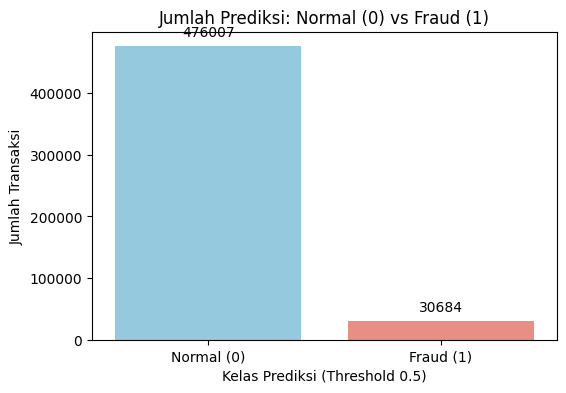


STATISTIK HASIL PREDIKSI
Total Data Test              : 506691
Rata-rata Probabilitas Fraud : 0.1175
Maksimum Probabilitas        : 1.0000
----------------------------------------
Diprediksi Aman (0)          : 476007
Diprediksi Fraud (1)         : 30684
Persentase Fraud             : 6.06%


In [ ]:
# 1. Load File Submission
# Pastikan file 'submission_final.csv' sudah ada dari tahap sebelumnya
try:
    print("Memuat file 'submission_final.csv'...")
    df_sub = pd.read_csv('submission_final.csv')
    print(f"File berhasil dimuat. Total data: {len(df_sub)} baris.")
except FileNotFoundError:
    print("ERROR: File 'submission_final.csv' tidak ditemukan. Pastikan Anda sudah menjalankan tahap prediksi sebelumnya.")
    # Stop eksekusi jika file tidak ada
    raise

# 2. Visualisasi 1: Histogram Distribusi Probabilitas
# Grafik ini menunjukkan seberapa 'yakin' model dalam memprediksi.
# Grafik yang baik akan menumpuk di kiri (nilai 0), karena Fraud itu jarang.
plt.figure(figsize=(10, 5))
sns.histplot(df_sub['isFraud'], bins=100, kde=True, color='purple')
plt.title('Distribusi Probabilitas Prediksi (Confidence Model)')
plt.xlabel('Probabilitas (0 = Aman, 1 = Fraud)')
plt.ylabel('Frekuensi')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.legend()
plt.show()

# 3. Visualisasi 2: Jumlah Prediksi Normal vs Fraud (Threshold 0.5)
# Menghitung prediksi kelas (0 atau 1)
df_sub['Prediksi_Kelas'] = df_sub['isFraud'].apply(lambda x: 1 if x >= 0.5 else 0)

plt.figure(figsize=(6, 4))

# Menggunakan palette list dan parameter hue untuk menghindari error
ax = sns.countplot(
    x='Prediksi_Kelas',
    data=df_sub,
    hue='Prediksi_Kelas',
    palette=['skyblue', 'salmon'], # List warna: Biru (0), Merah (1)
    legend=False
)

plt.title('Jumlah Prediksi: Normal (0) vs Fraud (1)')
plt.xlabel('Kelas Prediksi (Threshold 0.5)')
plt.ylabel('Jumlah Transaksi')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)']) # Label sumbu X agar lebih jelas

# Menambahkan angka di atas batang grafik
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 10),
                    textcoords = 'offset points')
plt.show()

# 4. Statistik Ringkas (Angka Pasti)
fraud_count = len(df_sub[df_sub['Prediksi_Kelas'] == 1])
total_count = len(df_sub)
fraud_percent = (fraud_count / total_count) * 100

print("\n" + "="*40)
print("STATISTIK HASIL PREDIKSI")
print("="*40)
print(f"Total Data Test              : {total_count}")
print(f"Rata-rata Probabilitas Fraud : {df_sub['isFraud'].mean():.4f}")
print(f"Maksimum Probabilitas        : {df_sub['isFraud'].max():.4f}")
print("-" * 40)
print(f"Diprediksi Aman (0)          : {total_count - fraud_count}")
print(f"Diprediksi Fraud (1)         : {fraud_count}")
print(f"Persentase Fraud             : {fraud_percent:.2f}%")
print("="*40)

Penjelasan Model:

Model ini bertujuan mendeteksi kecurangan transaksi (fraud detection) menggunakan algoritma LightGBM, yang dikenal efisien untuk data berskala besar. Proses dimulai dengan teknik optimasi memori yang krusial (reduce_mem_usage), mengingat dataset transaksi keuangan memiliki ukuran yang sangat besar. Data kemudian melalui tahap preprocessing yang meliputi pengisian nilai kosong (NaN) dengan angka -999 dan konversi data kategori menjadi angka (Label Encoding). Dataset latih dibagi dengan rasio 80:20 untuk memastikan model dapat divalidasi dengan data yang belum pernah dilihat sebelumnya.

Pemilihan Model Terbaik Dalam tahap pelatihan, dilakukan eksperimen perbandingan antara dua konfigurasi hyperparameter: Model A (konservatif) dan Model B (agresif dengan kompleksitas lebih tinggi). Hasil eksperimen menunjukkan bahwa Model B lebih unggul dalam membedakan pola transaksi, mencatatkan skor validasi AUC sebesar 0.9651, dibandingkan Model A yang hanya mencapai 0.9478. Berdasarkan metrik ini, Model B dipilih sebagai model final untuk melakukan prediksi karena kemampuannya yang lebih baik dalam memisahkan kelas positif (fraud) dan negatif (normal).

Evaluasi Kinerja Model Pada tahap evaluasi menggunakan data validasi, model menunjukkan performa yang sangat menjanjikan dengan skor ROC-AUC akhir 0.9651. Jika dilihat lebih dalam pada Classification Report untuk kelas Fraud (label 1), model memiliki Recall sebesar 0.83 dan Precision 0.44. Ini berarti model berhasil menangkap 83% dari seluruh kejadian fraud yang ada, yang merupakan prioritas utama dalam kasus keamanan finansial. Meskipun presisinya 0.44 (artinya ada sejumlah transaksi aman yang dicurigai sebagai fraud), trade-off ini wajar diterima demi meminimalisir lolosnya penipu.

Prediksi Akhir pada Data Uji Sebagai langkah terakhir, model diterapkan pada data Test yang berisi 506.691 transaksi tanpa label. Hasil analisis statistik submission menunjukkan bahwa model memprediksi sebanyak 30.684 transaksi (sekitar 6.06%) sebagai indikasi fraud. Distribusi probabilitas menunjukkan pola yang sehat (menumpuk di kiri/aman), dan persentase 6% ini dianggap realistis untuk kasus penipuan di dunia nyata, menandakan bahwa model telah bekerja dengan wajar dan tidak mengalami overfitting yang ekstrem.